In [1]:
#Importing necessary dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split 
from datetime import datetime
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

from plotly.subplots import make_subplots
%matplotlib inline
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile


2023-10-05 14:12:33.505864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 14:12:33.621101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-05 14:12:33.621119: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-05 14:12:33.644868: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-05 14:12:34.113996: W tensorflow/stream_executor/pla

In [2]:
# Creating models
# causal conv
def __causal_gated_conv1D(x=None, filters=16, length=6, strides=1):
    def causal_gated_conv1D(x, filters, length, strides):
        x_in_1 = layers.Conv1D(filters=filters // 2,
                               kernel_size=length,
                               dilation_rate=strides, 
                               strides=1,
                               padding="causal")(x)
        x_sigmoid = layers.Activation(activation="sigmoid")(x_in_1)

        x_in_2 = layers.Conv1D(filters=filters // 2,
                               kernel_size=length,
                               dilation_rate=strides,  
                               strides=1,
                               padding="causal")(x)
        x_tanh = layers.Activation(activation="tanh")(x_in_2)

        x_out = layers.Multiply()([x_sigmoid, x_tanh])

        return x_out

    if x is None:
        return lambda _x: causal_gated_conv1D(x=_x, filters=filters, length=length, strides=strides)
    else:
        return causal_gated_conv1D(x=x, filters=filters, length=length, strides=strides)


In [3]:
def Net(input_shape, classes, width_multiply=1):
    _x_in = layers.Input(shape=input_shape)

    # 1 block
    _x_up = __causal_gated_conv1D(filters=16 * width_multiply, length=3)(_x_in)
    _x_down = __causal_gated_conv1D(filters=16 * width_multiply, length=6)(_x_in)
    _x = layers.Concatenate()([_x_up, _x_down])

    # 2 block
    _x_up = __causal_gated_conv1D(filters=8 * width_multiply, length=3)(_x)
    _x_down = __causal_gated_conv1D(filters=8 * width_multiply, length=6)(_x)
    _x = layers.Concatenate()([_x_up, _x_down])

    # 3 block
    _x_up = __causal_gated_conv1D(filters=8 * width_multiply, length=3)(_x)
    _x_down = __causal_gated_conv1D(filters=8 * width_multiply, length=6)(_x)
    _x_concat = layers.Concatenate()([_x_up, _x_down])

    _x = layers.Add()([_x, _x_concat])

    # 4 block
    _x_loop1 = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=3)(_x)
    _x = layers.Add()([_x, _x_loop1])

    # 5 block
    _x_loop2 = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=2)(_x)
    _x = layers.Add()([_x, _x_loop2])

    # 6 block
    _x_loop3 = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=2)(_x)
    _x = layers.Add()([_x, _x_loop3])

    # 7 block
    _x_forward = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=2)(_x)

    # 8 block
    _x_loop4 = __causal_gated_conv1D(filters=32 * width_multiply, length=3, strides=2)(_x)

    # output
    _x = layers.Concatenate()([_x_loop2, _x_loop3, _x_forward, _x_loop4])
    _x = layers.Conv1D(filters=classes, kernel_size=1)(_x)
    _x = layers.GlobalAveragePooling1D()(_x)
    _x = layers.Activation("softmax")(_x)

    model = models.Model(inputs=_x_in, outputs=_x)

    return model

In [4]:
# Load the training data
X_train = np.load('/home/sae/training_data.npy')
y_train = np.load('/home/sae/training_labels.npy')

# Load the validation data (
X_validation = np.load('/home/sae/validation_data.npy')
y_validation = np.load('/home/sae/validation_labels.npy')

# Load the test data
X_test = np.load('/home/sae/testing_data.npy')
y_test = np.load('/home/sae/testing_labels.npy')

In [5]:
model = Net(input_shape=(40,87), classes=2,width_multiply=2) 
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
# Display model architecture summary
model.summary()

2023-10-05 14:12:54.390122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-05 14:12:54.390235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-05 14:12:54.390284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-05 14:12:54.390331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-10-05 14:12:54.390377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 87)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 40, 16)       4192        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 40, 16)       4192        ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 40, 16)       8368        ['input_1[0][0]']                
                                                                                              

In [6]:
#K fold validation & precision/recall calculation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

#Store accuracy and precision/recall
fold_precisions = []
fold_recalls = []

#F1 scores
fold_f1_scores = []
# Initialize an array of threshold values (e.g., from 0.1 to 0.9)
thresholds = np.arange(0.1, 1.0, 0.1)

#save confusion matrix
fold_cm = []

le = LabelEncoder()
num_epochs = 3
num_batch_size = 32

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Shuffle the validation data (if needed)
X_validation, y_validation = shuffle(X_validation, y_validation, random_state=42)

# Shuffle the test data
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Train the model

le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_validation_encoded = to_categorical(le.transform(y_validation))
y_test_encoded = to_categorical(le.transform(y_test))



# Train the model
num_epochs = 3
num_batch_size = 32

history = model.fit(X_train, y_train_encoded, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_validation, y_validation_encoded), verbose=1)

# Evaluate the model on the final test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

# Predict on the test set (this should give prediction and associated probabilities)
y_test_pred = model.predict(X_test)

for threshold in thresholds:
    y_test_pred_thresholded = (y_test_pred[:, 1] > threshold).astype(int)  # Adjust the column index if needed
    cm = confusion_matrix(y_test_encoded[:, 1], y_test_pred_thresholded)

    # Calculate TP, FP, FN for the current threshold
    precision = precision_score(y_test_encoded[:, 1], y_test_pred_thresholded)
    recall = recall_score(y_test_encoded[:, 1], y_test_pred_thresholded)

    # Calculate F1 score using precision and recall
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_cm.append(cm)
    fold_f1_scores.append(f1)

k = 10 # 10 fold validation
# cv = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# Combine training, validation, and testing data
# X_combined = np.concatenate((X_train, X_validation, X_test))
# y_combined = np.concatenate((y_train, y_validation, y_test))


# Perform k-fold cross-validation
# for train_idx, validation_idx, test_idx in cv.split(X_combined, y_combined):
#     X_train_fold, y_train_fold = X_combined[train_idx], y_combined[train_idx]
#     X_validation_fold, y_validation_fold = X_combined[validation_idx], y_combined[validation_idx]
#     X_test_fold, y_test_fold = X_combined[test_idx], y_combined[test_idx]
    
#     y_train_encoded = to_categorical(le.fit_transform(y_train))
#     y_validation_encoded = to_categorical(le.transform(y_validation))
#     y_test_encoded = to_categorical(le.transform(y_test))

#     #Compile a model
#     model = Net(input_shape=(40,87), classes=2,width_multiply=2) 
#     # Compile the model
#     model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
#     # # Display model architecture summary
#     # model.summary()
    
#     # Train your model on X_train_fold and y_train_fold
#     history = model.fit(X_train_fold, y_train_encoded, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_validation_fold, y_validation_encoded), verbose=1)

#     # Make predictions on the testing set
#     y_test_pred = model.predict(X_test_fold)

#     # Calculate accuracy for this fold
#     fold_accuracy = accuracy_score(y_test_fold, y_test_pred)
#     results.append(fold_accuracy)
    
#      # Convert predictions and true labels to binary format for precision and recall calculation
#     y_test_pred_binary = np.argmax(y_test_pred, axis=1)
#     y_test_fold_binary = np.argmax(y_test_encoded, axis=1)

#     # Calculate precision and recall for this fold
#     fold_precision = precision_score(y_test_fold_binary, y_test_pred_binary)
#     fold_recall = recall_score(y_test_fold_binary, y_test_pred_binary)
    
#     fold_precisions.append(fold_precision)
#     fold_recalls.append(fold_recall)
    
#     f1_scores = []
#     for threshold in thresholds:
#         y_test_pred_thresholded = (y_test_pred[:, 1] > threshold).astype(int)  # Adjust the column index if needed

#         # Calculate TP, FP, FN for the current threshold
#         TP = np.sum((y_test_fold_binary == 1) & (y_test_pred_thresholded == 1))
#         FP = np.sum((y_test_fold_binary == 0) & (y_test_pred_thresholded == 1))
#         FN = np.sum((y_test_fold_binary == 1) & (y_test_pred_thresholded == 0))

#         # Calculate precision and recall for the current threshold
#         precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#         recall = TP / (TP + FN) if (TP + FN) > 0 else 0

#         # Calculate F1 score using precision and recall
#         f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#         f1_scores.append(f1)

#     fold_f1_scores.append(f1_scores)

# # Calculate mean and standard deviation of accuracy scores
# mean_accuracy = np.mean(results)
# std_accuracy = np.std(results)

# # Calculate mean precision and recall scores over all folds
# mean_precision = np.mean(fold_precisions)
# mean_recall = np.mean(fold_recalls)

# # Calculate mean F1 scores over all folds
# mean_f1_scores = np.mean(fold_f1_scores, axis=0)


Epoch 1/3
437/437 [==============================] - 11s 21ms/step - loss: 0.4589 - accuracy: 0.7621 - val_loss: 0.4578 - val_accuracy: 0.7979
Epoch 2/3
437/437 [==============================] - 8s 19ms/step - loss: 0.2766 - accuracy: 0.8854 - val_loss: 0.2550 - val_accuracy: 0.8896
Epoch 3/3
34/34 [==============================] - 0s 8ms/step - loss: 0.2715 - accuracy: 0.8741
Test loss: 0.2715, Test accuracy: 0.8741
34/34 [==============================] - 1s 7ms/step


Fold 0.1   Precision:  0.8811188811188811   Recall:  0.9264705882352942  F1 Score:  0.903225806451613
Fold 0.2   Precision:  0.9017013232514177   Recall:  0.8768382352941176  F1 Score:  0.8890959925442684
Fold 0.30000000000000004   Precision:  0.9156626506024096   Recall:  0.8382352941176471  F1 Score:  0.8752399232245681
Fold 0.4   Precision:  0.9233954451345756   Recall:  0.8198529411764706  F1 Score:  0.8685491723466408
Fold 0.5   Precision:  0.9376344086021505   Recall:  0.8014705882352942  F1 Score:  0.8642220019821605
Fold 0.6   Precision:  0.9465478841870824   Recall:  0.78125  F1 Score:  0.8559919436052366
Fold 0.7000000000000001   Precision:  0.9537037037037037   Recall:  0.7573529411764706  F1 Score:  0.8442622950819672
Fold 0.8   Precision:  0.9604938271604938   Recall:  0.7150735294117647  F1 Score:  0.8198103266596417
Fold 0.9   Precision:  0.9672131147540983   Recall:  0.6507352941176471  F1 Score:  0.778021978021978
  Mean precision:  0.9319412487238681   Mean recall:  0

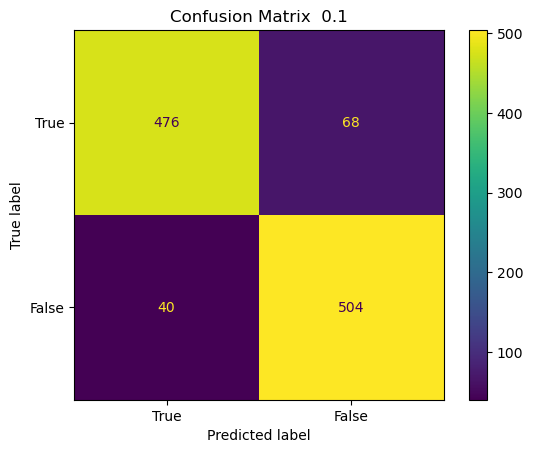

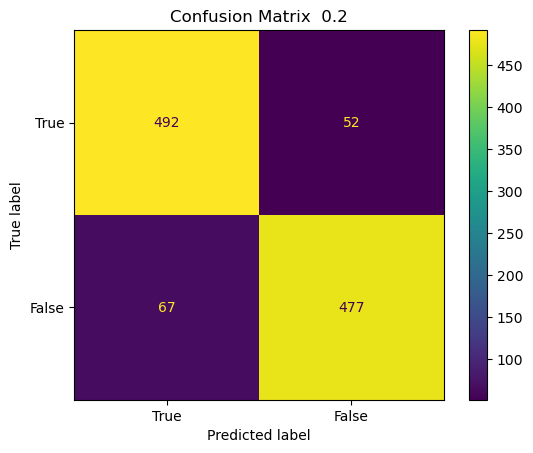

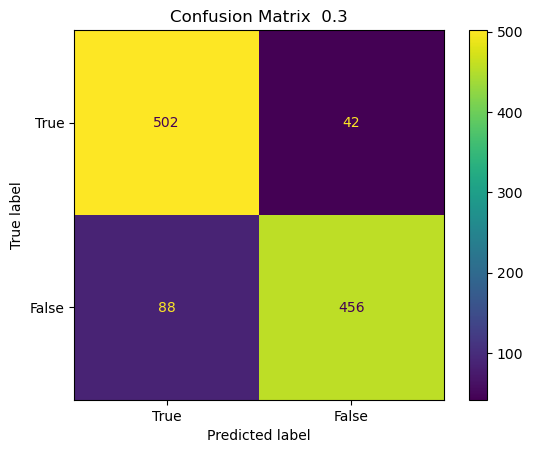

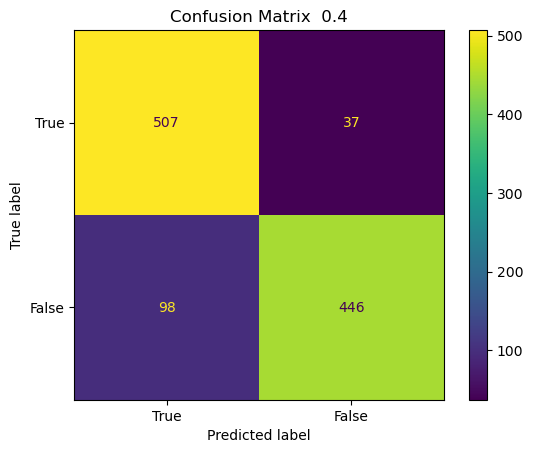

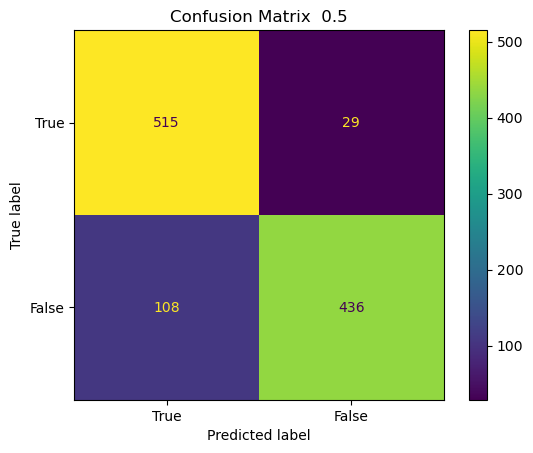

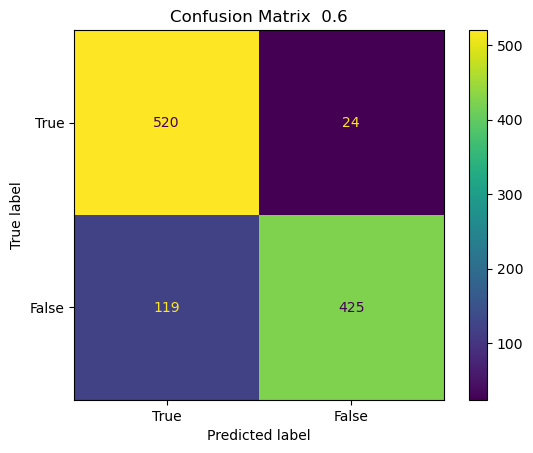

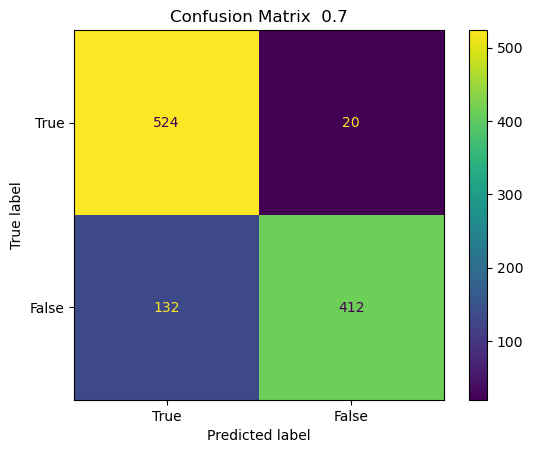

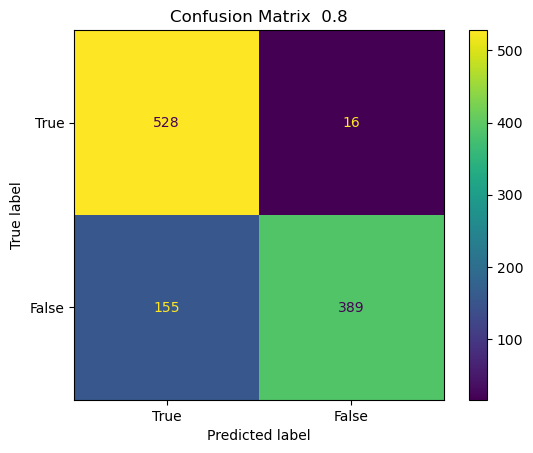

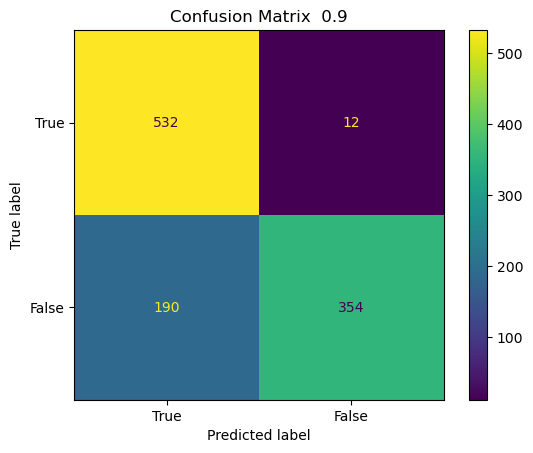

In [7]:

# Calculate mean F1 scores over all folds
mean_f1_scores = np.mean(fold_f1_scores, axis=0)
mean_recall = np.mean(fold_recalls, axis=0)
mean_precision = np.mean(fold_precisions, axis=0)

for i in range(len(thresholds)):
     print("Fold", i*0.1+0.1, "  Precision: ", fold_precisions[i], "  Recall: ", fold_recalls[i], " F1 Score: ", fold_f1_scores[i])

print("  Mean precision: ", mean_precision, "  Mean recall: ", mean_recall, " Mean F1 Score: ", mean_f1_scores)

#Print confusion matrix
import matplotlib.pyplot as metrics
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(len(fold_cm)):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = fold_cm[i], display_labels = [True, False])
    cm_display.plot()
    title = i * 0.1+0.1
     
    plt.title(f'Confusion Matrix {title: .1f}')
    plt.show()

In [ ]:
# #Print results

# for i in range(0, k):
#     print("Accuracy: ", results[i], "  Precision: ", fold_precision[i], "  Recall: ", fold_recall[i], " F1 Score: ", fold_f1_scores[i])

# print("Mean accuracy: ",  mean_accuracy, "  Mean precision: ", mean_precision, "  Mean recall: ", mean_recall, " Mean F1 Score: ", mean_f1_scores)
    

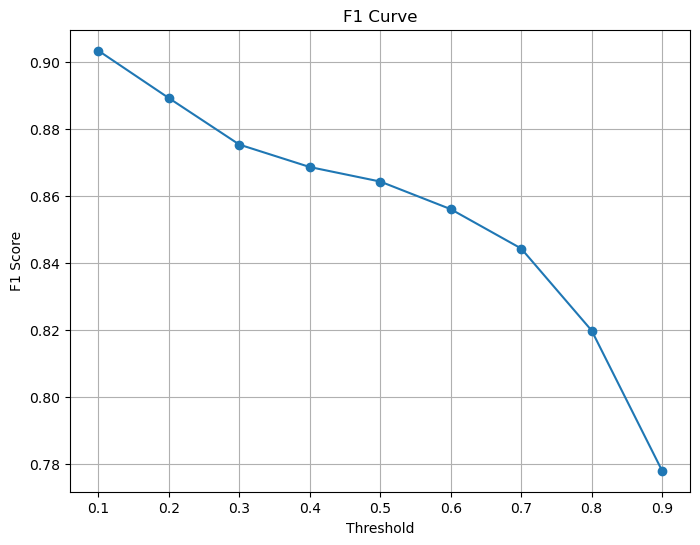

Mean F1 Score: 0.8554


In [8]:
#Plot the F1 curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fold_f1_scores, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.grid(True)
plt.show()

# Display the mean F1 score
print(f"Mean F1 Score: {mean_f1_scores:.4f}")



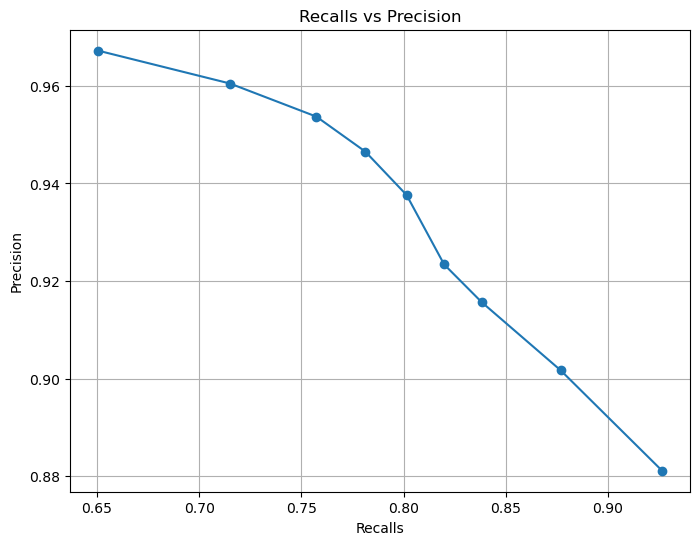

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(fold_recalls, fold_precisions, marker='o', linestyle='-')
plt.xlabel('Recalls')
plt.ylabel('Precision')
plt.title('Recalls vs Precision')
plt.grid(True)
plt.show()
